# Part 2: Forecasting prices and rents

### Work to do

The purpose of this segment is to create underwriting model in a form familiar to a real estate analyst that helps them understand the expected
returns for properties in this area.

1. Collect a small number of causal datasets that we expect to explain property price and rental income growth. These should include:
    
    For prices & rents:
    - UK National GDP
    - UK National CPI
    - UK Household income growth
    - Local population growth for the postcode (or as close to local data as you can find)


    Costs:

    - UK CPI / London CPI

Use the forecasting library developed by Vitalii (cc'd here) to construct a simple causal forecasting model of the prices, rents and costs. You can work with him
to get access to the underlying model object that gets created so you can perform feature salience analysis etc.

2. For each property size, create a projection of the rent growth and price increase over the next 10 years
3. Create a simple financial model of the investment in the property over the coming 10 years. In Real Estate team, the analysts use excel. Therefore
we will use excelwings or pyexcel to update this initial excel model with the input assumptions that you generate above. Stephen (cc'd) will be able to help
prepare a very simple excel model and answer any modelling questions you have.
4. Use charts to present the results of this analysis and the properties with the highest expected return

1) Have all the data except for LONDON CPI, which I have the national.  For the population growth I have only until 2011. Use data for Brent, whhich contains Killburn (Nw6)

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import requests
import utilities
from functools import reduce


-----------

## DATA LOADING

- [X] GDP (https://countryeconomy.com/gdp/uk) # has not yet been calculated for 2019
- [X] CPI (https://www.inflation.eu/inflation-rates/great-britain/historic-inflation/cpi-inflation-great-britain.aspx)
- [X] House Hold income (https://www.ons.gov.uk/peoplepopulationandcommunity/personalandhouseholdfinances/incomeandwealth/bulletins/householddisposableincomeandinequality/financialyearending2019provisional)
- [X] Population grotwh (https://data.london.gov.uk/dataset/historical-census-tables, https://data.brent.gov.uk/dataset/population-change-in-brent---key-facts population change)

### GDP

We have GDP data from 1971 until 2018

In [3]:
gdp = pd.read_csv('./part2_data/GDP.csv').rename(columns={'Year':'year'})
gdp['GDP'] = gdp['GDP'].str.strip('M.$').str.replace(',', '').astype(int)
gdp['Growth'] = gdp['Growth'].str.replace('%','').astype(float)

In [4]:
print(gdp.head())
print('\t\t\t',gdp.shape)

   year      GDP  Growth
0  2018  2828833     1.4
1  2017  2640067     1.9
2  2016  2669107     1.9
3  2015  2897060     2.4
4  2014  3036310     2.6
			 (48, 3)


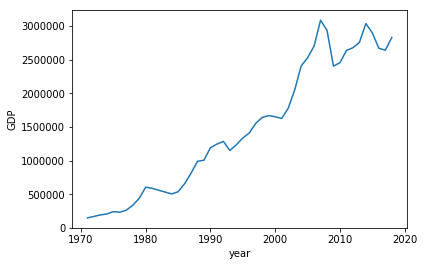

In [5]:
sns.lineplot(x=gdp['year'],y=gdp['GDP'])

### CPI

In [6]:
cpi = pd.read_csv('./part2_data/CPI.csv')
cpi['year'] = cpi['year'].str.split(' ').str[-1].astype(int)
cpi['CPI'] = cpi['CPI'].str.replace('%','').str.strip().astype(float)

In [7]:
print(cpi.head())
print('\t\t\t',cpi.shape)

   year   CPI
0  2019  1.81
1  2018  2.29
2  2017  2.56
3  2016  1.01
4  2015  0.37
			 (64, 2)


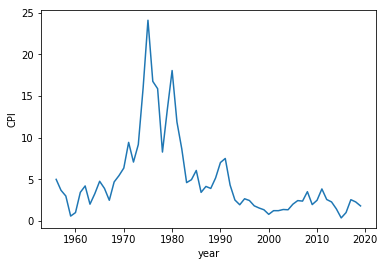

In [8]:
sns.lineplot(x=cpi['year'],y=cpi['CPI'])

###  HouseHold Income

In [9]:
hhi = pd.read_csv('./part2_data/HHI.csv', names = ['year', 'median', 'mean'], skiprows=1)
hhi = hhi.sort_values(by='year', ascending=False)

In [10]:
print(hhi.head())
print('\t\t\t',hhi.shape)

    year  median   mean
41  2018   220.1  237.2
40  2017   217.0  234.4
39  2016   217.1  230.1
38  2015   211.6  224.9
37  2014   208.3  222.2
			 (42, 3)


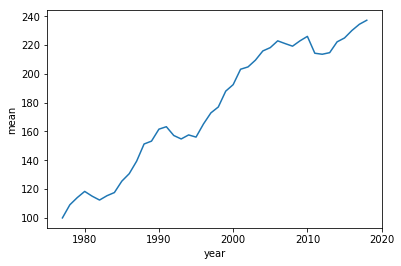

In [11]:
sns.lineplot(x=hhi['year'],y=hhi['mean'])

### Population Growth

In [12]:
ppg = pd.read_csv('./part2_data/PPG.csv', index_col=0)

ppg = pd.Series(ppg.loc['Brent'])

ppg.index = pd.to_datetime(ppg.index)

In [13]:
# AS we have the data every 10 years we can interpolate the points
ppg = ppg.resample('Y').first().interpolate(memoryviewthod='linear')

In [14]:
ppg = pd.DataFrame(ppg).reset_index().rename(columns={'index':'year', 'Brent':'PPG'})
ppg['year'] = ppg['year'].dt.year

In [15]:
print(ppg.head())
print('\t\t\t',ppg.shape)

   year     PPG
0  1801  2000.0
1  1802  2000.0
2  1803  2000.0
3  1804  2000.0
4  1805  2000.0
			 (219, 2)


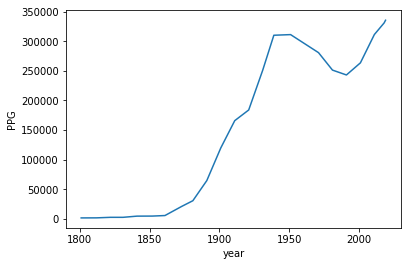

In [16]:
sns.lineplot(data=ppg, x='year', y='PPG')

-------------------

### Data merging

In [17]:
dfs_to_merge = [gdp,cpi,hhi,ppg]

In [18]:
fulldf = reduce(lambda left, right: pd.merge(left, right, on='year', how='inner'), dfs_to_merge)

In [19]:
fulldf.head()
print(fulldf.head())
print('\t\t\t',fulldf.shape)

   year      GDP  Growth   CPI  median   mean            PPG
0  2018  2828833     1.4  2.29   220.1  237.2  330800.000000
1  2017  2640067     1.9  2.56   217.0  234.4  328002.142857
2  2016  2669107     1.9  1.01   217.1  230.1  325204.285714
3  2015  2897060     2.4  0.37   211.6  224.9  322406.428571
4  2014  3036310     2.6  1.45   208.3  222.2  319608.571429
			 (42, 7)


-----------

## Building the predictive models and the forecasting

First we need to extend the explicative variables and so we will do a forecast 10 years into the future for each of them.

To check the code please look into **utilities.py**. It contains the wrappers to easily make the predictions.

In [20]:
import utilities

### Forecasting independent variables

In [21]:
predictions = fulldf.set_index('year').apply(utilities.forecast, freq='A', fh=10, \
                                             endpoint='https://deciml-forecast.com/apiworkers/ts_panel-all')\
                                      .reset_index()
predictions['year'] = predictions['year'].str[0:4].astype(int)

Finished forecasting:  GDP
Finished forecasting:  GDP
Finished forecasting:  Growth
Finished forecasting:  CPI
Finished forecasting:  median
Finished forecasting:  mean
Finished forecasting:  PPG


In [22]:
fulldf = pd.concat([fulldf, predictions]).sort_values(by='year')

In [23]:
melted_df = fulldf.melt(id_vars=['year'])

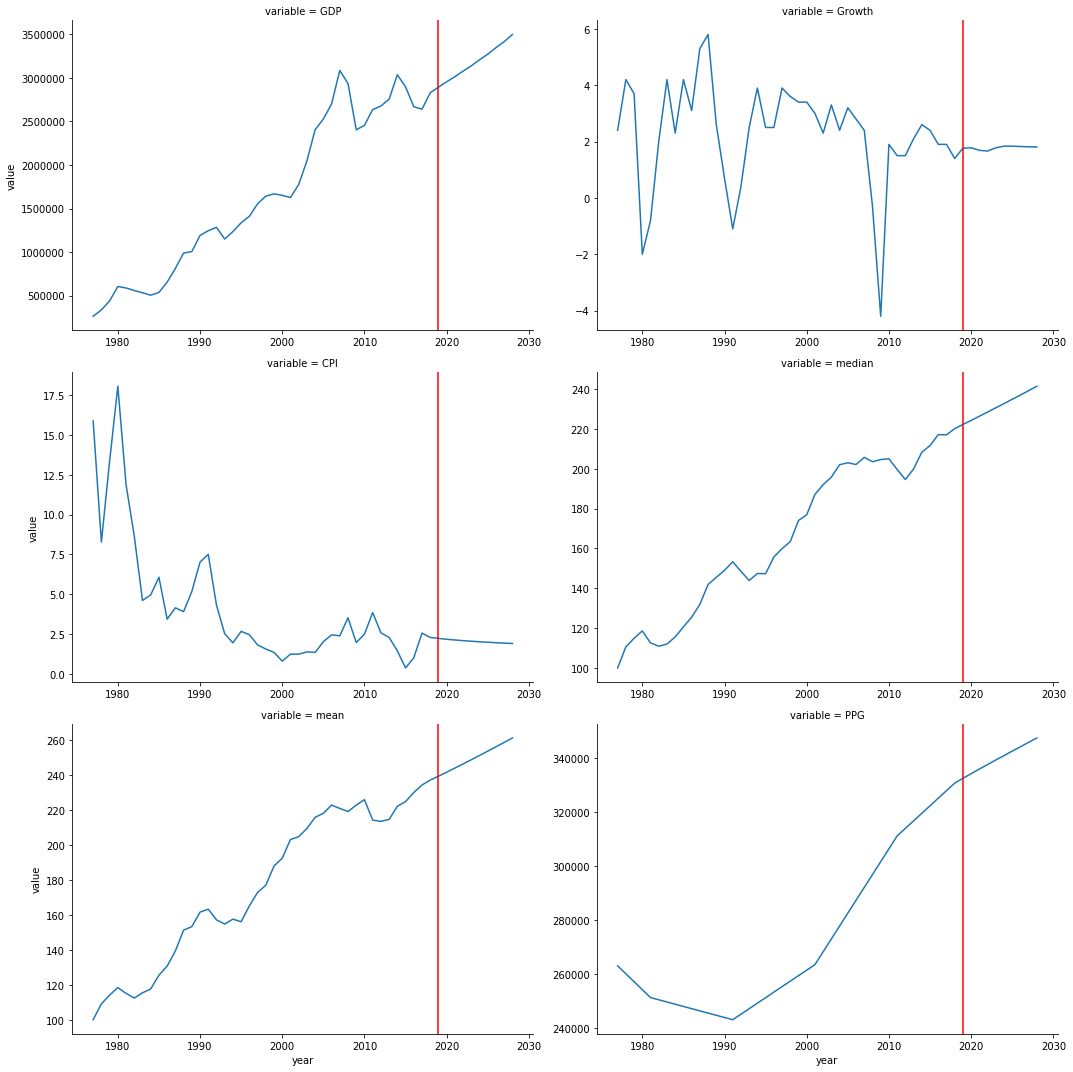

In [24]:
g = sns.FacetGrid(melted_df, col="variable", sharey=False, sharex=False, \
                  aspect=1.5, col_wrap=2, height=5)
g.map(plt.plot, 'year', 'value')

for ax in g.axes:
    ax.axvline(2019, c='red')

plt.show()

### Loading rents and prices

In [25]:
def direction_to_postcode(df, direction_col, dir_pc):
    df['road'] = df[direction_col].str.split(',').str[0].str.strip().str.lower().str.lstrip(' 1234567890')
    df['road2'] = df[direction_col].str.split(',').str[1].str.strip().str.lower().str.lstrip(' 1234567890')
    df = df.replace({'road': dir_pc, 'road2':dir_pc})
    
    df.loc[~df['road'].str.startswith('NW'),'road'] = rents['road2']

    df = df.loc[df['road'].str.startswith('NW'),:]
    
    df['district'] = df['road'].str[-1]
    
    df.drop(['road', 'road2'],1, inplace=True)
    
    return df

In [26]:
# Load sale data
sales = pd.read_csv('nw6_data_price_fut_years_prediction.csv', index_col=0)
sales.loc[sales['beds']>=4,'beds'] = 4
sales['district'] = sales['postcode'].str[4]

In [27]:
# Load postcode data
postcodes = pd.read_csv('./postcode_NW6_to_roads.csv', index_col=0)
postcodes = postcodes.to_dict()['roads']
postcodes = {key:eval(postcodes[key]) for key in postcodes.keys()}
to_postcodes = {road.lower().replace('\'',''):\
                postcode for postcode in postcodes.keys() for road in postcodes[postcode]}

In [28]:
# Load rent data
rents = pd.read_csv('nw6_data_rent_prev_years_prediction.csv', index_col=0)\
          .rename(columns={'price': 'rent'})
rents = direction_to_postcode(rents, 'direction', to_postcodes)

In [29]:
# Merge the data

rents_agg = rents.groupby(['beds', 'year', 'district'])['rent'].mean().reset_index()

full_data =  sales.merge(rents_agg, on=['beds', 'year', 'district'])

full_data['district'] = full_data['district'].astype(int)

full_data['yield'] = 12*100*full_data['rent']/full_data['price']

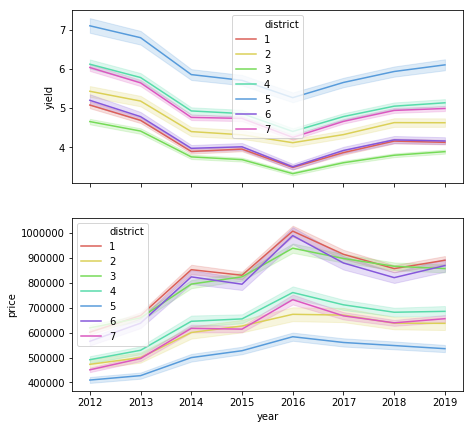

In [30]:
f, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

sns.lineplot(y='yield', x='year', data=full_data, hue='district', \
             palette=sns.color_palette("hls", 7), ax=axes[0])

sns.lineplot(y='price', x='year', data=full_data, hue='district', \
             palette=sns.color_palette("hls", 7), ax=axes[1])

plt.show()

In [31]:
beds = full_data['beds'].unique()
districts = full_data['district'].unique()

agg_data = full_data.groupby(['beds', 'district', 'year'])['price', 'rent'].mean()


for bed in beds:
    for district in districts:
        _ = agg_data.loc[bed, district]
        _ = _.join(fulldf.set_index('year'), how='outer')
        _train = _.dropna().reset_index()
        _test = _.loc[max(_train['year'])+1:].reset_index()
        break

In [32]:
def forecast_ML(ser, freq='A', fh = 10, 
                endpoint='http://apiforecastingservice-env.fwc2bt4dpa.us-east-2.elasticbeanstalk.com/ml_forecasts'):
    """
    Takes a pandas series and makes a call to the forecasting ML API
    to predict future values.
    
    This functions is inteded to be used as a pandas.DataFrame.apply
    method. 
    
    Parameters:
    
        ser (str): a pandas.Series object.
        fh (int): forecasting horizon to make the predictions.
        freq (str): frequency for the predictions. 'A' for Annually
                    'M' for Monthly, etc.
    Returns:
    
        pandas.DataFrame: a pandas Dataframe containing the
                          predictions from the API for the
                          corresponding forecasting horizon.
    
    """
    df = pd.DataFrame(ser).reset_index()
    par = prepare_query(df, freq=freq, fh = fh, column_time='year', 
                        column_data=df.columns[1])
    predictions = make_predictions(par, endpoint)
    predictions = predictions.rename(columns={'ds':'year', 'yhat':df.columns[1]})
    predictions = predictions.set_index('year')
    print('Finished forecasting: ', df.columns[1])
    return predictions[df.columns[1]]

In [116]:
import importlib
utilities = importlib.reload(utilities)

In [34]:
p = utilities.prepare_query(_train, column_data='price', column_time='year', 
                        ind_vars=['GDP'], just_set=True,
                        test_set=_test)

In [35]:
def make_predictions(params, url):
    """
    Takes a set of parameters to call the API and retrieve the 
    predictions.
    
    Parameters:
    
        params (str): a JSON containing the relevant parameters.
                      Use prepare_query to get one.
        
        url (str): the URL to use for the request. Check the 
                   the documentation for a list of them.
    Returns:
    
        pandas.DataFrame: a pandas Dataframe containing the
                          predictions from the API for the
                          corresponding forecasting horizon.
    
    """
    
    headers = {'Content-Type': 'application/json'}
    result = requests.post(url, data=params, headers=headers)
    return result
    result = pd.DataFrame(json.loads(result.text))
    
    return result

In [36]:
respond = make_predictions(p, 'http://ec2-18-221-69-88.us-east-2.compute.amazonaws.com:8000/ml_forecasts/')

In [44]:
eval(p)

{'train': [{'GDP': 2677082.0, 'y': 308412.3191514715, 'ds': '2012-01-01'},
  {'GDP': 2755356.0, 'y': 328585.5867642741, 'ds': '2013-01-01'},
  {'GDP': 3036310.0, 'y': 392438.5262163513, 'ds': '2014-01-01'},
  {'GDP': 2897060.0, 'y': 412324.9841201634, 'ds': '2015-01-01'},
  {'GDP': 2669107.0, 'y': 433107.4404640017, 'ds': '2016-01-01'},
  {'GDP': 2640067.0, 'y': 411639.1873442498, 'ds': '2017-01-01'},
  {'GDP': 2828833.0, 'y': 408428.3528821782, 'ds': '2018-01-01'},
  {'GDP': 2892935.002, 'y': 417633.5627392778, 'ds': '2019-01-01'}],
 'test': [{'GDP': 2955233.8711, 'y': 1.0, 'ds': '2020-01-01'},
  {'GDP': 3013129.6125, 'y': 1.0, 'ds': '2021-01-01'},
  {'GDP': 3078179.4152, 'y': 1.0, 'ds': '2022-01-01'},
  {'GDP': 3138752.6409, 'y': 1.0, 'ds': '2023-01-01'},
  {'GDP': 3208045.146, 'y': 1.0, 'ds': '2024-01-01'},
  {'GDP': 3272544.2988, 'y': 1.0, 'ds': '2025-01-01'},
  {'GDP': 3347328.5248, 'y': 1.0, 'ds': '2026-01-01'},
  {'GDP': 3416838.7643, 'y': 1.0, 'ds': '2027-01-01'},
  {'GDP': 349

In [37]:
respond

<Response [400]>

In [305]:
p

'{"train": [{"GDP": 2677082.0, "y": 308412.3191514715, "ds": "2012-01-01"}, {"GDP": 2755356.0, "y": 328585.5867642741, "ds": "2013-01-01"}, {"GDP": 3036310.0, "y": 392438.5262163513, "ds": "2014-01-01"}, {"GDP": 2897060.0, "y": 412324.9841201634, "ds": "2015-01-01"}, {"GDP": 2669107.0, "y": 433107.4404640017, "ds": "2016-01-01"}, {"GDP": 2640067.0, "y": 411639.1873442498, "ds": "2017-01-01"}, {"GDP": 2828833.0, "y": 408428.3528821782, "ds": "2018-01-01"}, {"GDP": 2892935.002, "y": 417633.5627392778, "ds": "2019-01-01"}], "test": [{"GDP": 2955233.8711, "y": 1.0, "ds": "2020-01-01"}, {"GDP": 3013129.6125, "y": 1.0, "ds": "2021-01-01"}, {"GDP": 3078179.4152, "y": 1.0, "ds": "2022-01-01"}, {"GDP": 3138752.6409, "y": 1.0, "ds": "2023-01-01"}, {"GDP": 3208045.146, "y": 1.0, "ds": "2024-01-01"}, {"GDP": 3272544.2988, "y": 1.0, "ds": "2025-01-01"}, {"GDP": 3347328.5248, "y": 1.0, "ds": "2026-01-01"}, {"GDP": 3416838.7643, "y": 1.0, "ds": "2027-01-01"}, {"GDP": 3498262.6415, "y": 1.0, "ds": "20

In [41]:
eval(respond.content)['detail']

'Traceback (most recent call last):\n  File "api.py", line 39, in ml_forecasts\n    return create_forecasts(train, test, methods_list, key)\n  File "api.py", line 23, in create_forecasts\n    forecaster_object = Forecaster(train, test, methods_list, key)\n  File "/home/ec2-user/forecast/forecaster.py", line 97, in __init__\n    assert len(selected) > 0, "no predictive features could be identified, try a univariate method"\nAssertionError: no predictive features could be identified, try a univariate method\n'

In [289]:
pp

'{"train": [{"GDP": 2677082.0, "Growth": 1.5, "CPI": 2.58, "median": 194.6, "mean": 213.6, "PPG": 314012.8571428572, "y": 308412.3191514715, "ds": "2012-01-01"}, {"GDP": 2755356.0, "Growth": 2.1, "CPI": 2.29, "median": 199.9, "mean": 214.7, "PPG": 316810.7142857143, "y": 328585.5867642741, "ds": "2013-01-01"}, {"GDP": 3036310.0, "Growth": 2.6, "CPI": 1.45, "median": 208.3, "mean": 222.2, "PPG": 319608.5714285714, "y": 392438.5262163513, "ds": "2014-01-01"}, {"GDP": 2897060.0, "Growth": 2.4, "CPI": 0.37, "median": 211.6, "mean": 224.9, "PPG": 322406.4285714286, "y": 412324.9841201634, "ds": "2015-01-01"}, {"GDP": 2669107.0, "Growth": 1.9, "CPI": 1.01, "median": 217.1, "mean": 230.1, "PPG": 325204.2857142857, "y": 433107.4404640017, "ds": "2016-01-01"}, {"GDP": 2640067.0, "Growth": 1.9, "CPI": 2.56, "median": 217.0, "mean": 234.4, "PPG": 328002.1428571428, "y": 411639.1873442498, "ds": "2017-01-01"}, {"GDP": 2828833.0, "Growth": 1.4, "CPI": 2.29, "median": 220.1, "mean": 237.2, "PPG": 33